In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1D Benchmarking for 10 particles on 10 sites

In [3]:
# Skip the commented header line that starts with #
vmc_1D_path = "../data/vmc_scan_vs_U.dat"
df_VMC_1D = pd.read_csv(vmc_1D_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem"])

exact_1D_path = "../data/exact_1D_10_10.dat"
df_exact_1D = pd.read_csv(exact_1D_path, delim_whitespace=True, comment="#", header=None)
df_exact_1D.columns = ["U", "Eg", "K", "V", "S₁(ℓ=5)", "S₁acc(ℓ=5)", "S₂(ℓ=5)", "S₂acc(ℓ=5)", "EN(ℓ=5)", "ENacc(ℓ=5)"]

df_1D = pd.merge(df_exact_1D, df_VMC_1D, on="U")
print(df_1D)

      U         Eg          K         V   S₁(ℓ=5)  S₁acc(ℓ=5)   S₂(ℓ=5)  \
0   1.0 -16.360486 -19.489670  3.129184  1.601525    0.093800  1.394409   
1   2.0 -13.535967 -18.656496  5.120529  1.493330    0.127659  1.264016   
2   3.0 -11.193913 -17.602329  6.408416  1.400145    0.147413  1.146629   
3   4.0  -9.251593 -16.252032  7.000439  1.292443    0.165206  0.993954   
4   5.0  -7.692948 -14.538391  6.845443  1.137049    0.174864  0.778945   
5   6.0  -6.499789 -12.675265  6.175475  0.935820    0.160943  0.553644   
6   7.0  -5.605177 -11.029746  5.424570  0.745443    0.131160  0.388219   
7   8.0  -4.923598  -9.716730  4.793132  0.598289    0.102276  0.283606   
8   9.0  -4.389254  -8.678298  4.289045  0.490430    0.079961  0.216842   
9  10.0  -3.959169  -7.840723  3.881554  0.410437    0.063655  0.171872   

   S₂acc(ℓ=5)   EN(ℓ=5)  ENacc(ℓ=5)    kappa     energy       sem  
0    0.036664  1.980086    0.293316  0.95000 -10.435217  0.001146  
1    0.053049  1.919919    0.366878  0

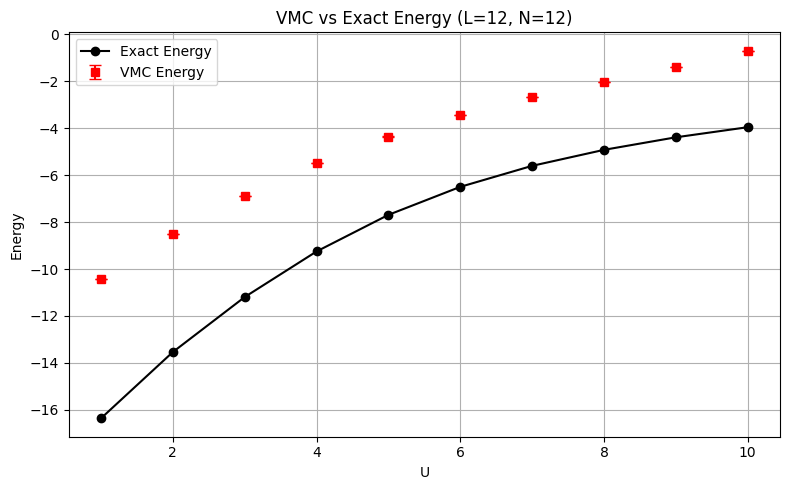

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(df_1D["U"], df_1D["Eg"], label="Exact Energy", marker='o', color='black')
plt.errorbar(df_1D["U"], df_1D["energy"], yerr=df_1D["sem"], label="VMC Energy", fmt='s', capsize=4, color='red')

plt.xlabel("U")
plt.ylabel("Energy")
plt.title("VMC vs Exact Energy (L=12, N=12)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/1D_12_12.pdf", dpi=600)
plt.show()

# 2D Benchmarking for 4 particles on a 2x2 lattice 
Ran PIMC with the following:

julia pigsfli.jl -D 2 -L 16 -N 16 -l 2 -U 1.0 --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

In [3]:
vmc_2D_path = "../data/vmc_scan_vs_U.dat"
df_VMC_2D = pd.read_csv(vmc_2D_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem"])

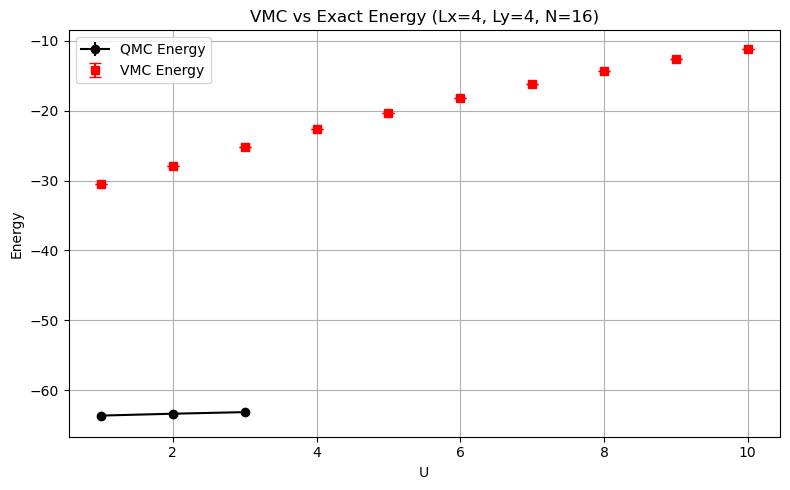

In [5]:
# Define data directory
data_dir = "../data/QMC/"

# Regex pattern for K or V energy files
pattern = re.compile(
    r"(K|V)_2D_L16_N16_M256_l2_U([0-9.]+)_t1.0000_beta1.0000_binsize10000_seed2001_square_trialstate_constant\.dat"
)

# Store energy statistics
energy_data = {}

for fname in os.listdir(data_dir):
    match = pattern.match(fname)
    if match:
        kind = match.group(1)         # 'K' or 'V'
        U_val = float(match.group(2)) # Extract U
        fpath = os.path.join(data_dir, fname)

        df = pd.read_csv(fpath, delim_whitespace=True, header=None)
        mean = df[0].mean()
        std = df[0].std()

        if U_val not in energy_data:
            energy_data[U_val] = {}

        energy_data[U_val][f"{kind}_mean"] = mean
        energy_data[U_val][f"{kind}_std"] = std

# Construct DataFrame
df_energy = pd.DataFrame.from_dict(energy_data, orient="index")
df_energy.index.name = "U"
df_energy.sort_index(inplace=True)

# Compute total energy and uncertainty
df_energy["Total_mean"] = df_energy["K_mean"] + df_energy["V_mean"]
df_energy["Total_std"] = (df_energy["K_std"]**2 + df_energy["V_std"]**2)**0.5

plt.figure(figsize=(8, 5))
plt.errorbar(df_energy.index, df_energy["Total_mean"], yerr=df_energy["Total_std"], label="QMC Energy", marker='o', color='black')
plt.errorbar(df_VMC_2D["U"], df_VMC_2D["energy"], yerr=df_VMC_2D["sem"], label="VMC Energy", fmt='s', capsize=4, color='red')

plt.xlabel("U")
plt.ylabel("Energy")
plt.title("VMC vs Exact Energy (Lx=4, Ly=4, N=16)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/2D_2_4.pdf", dpi=600)
plt.show()